In [29]:
import pandas as pd

def clean_dataframe(df):
    # Remove rows where Player column contains 'Player' (these are repeated headers)
    df = df[df[('Unnamed: 1_level_0', 'Player')] != 'Player']
    return df

def scrape_metrics(min_90s=6):
    # Possession data
    df_possession = pd.read_html("https://fbref.com/en/comps/Big5/possession/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_possession"})[0]
    
    df = df_possession[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 3_level_0', 'Pos'),
        ('Unnamed: 8_level_0', '90s'),
        ('Carries', 'CPA'),
        ('Carries', 'Dis'),
        ('Touches', 'Att Pen'),
    ]]
    
    # Clean the dataframe to remove repeated headers
    df = clean_dataframe(df)
    
    # Create unique identifier
    df['player_id'] = df[('Unnamed: 1_level_0', 'Player')] + ' - ' + df[('Unnamed: 4_level_0', 'Squad')]

    # Misc data
    df_misc = pd.read_html("https://fbref.com/en/comps/Big5/misc/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_misc"})[0]
    df_misc = df_misc[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Performance', 'Fld'), 
        ('Performance', 'Off')
    ]]
    df_misc = clean_dataframe(df_misc)
    df_misc['player_id'] = df_misc[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_misc[('Unnamed: 4_level_0', 'Squad')]

    # First merge
    df = pd.merge(
        df,
        df_misc.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Passing data
    df_passing = pd.read_html("https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_passing"})[0]
    df_pass_cmp = df_passing[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 29_level_0', 'PPA'),
        ('Unnamed: 27_level_0', 'KP'),
        ('Unnamed: 24_level_0', 'xAG'),
        ('Total', 'Cmp'),
        ('Total', 'Att')
    ]]
    df_pass_cmp = clean_dataframe(df_pass_cmp)
    df_pass_cmp['player_id'] = df_pass_cmp[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_pass_cmp[('Unnamed: 4_level_0', 'Squad')]

    # Second merge
    df = pd.merge(
        df,
        df_pass_cmp.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Shooting data
    df_shooting = pd.read_html("https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_shooting"})[0]
    df_shooting = df_shooting[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Expected', 'npxG'),
        ('Expected', 'np:G-xG'),
        ('Expected', 'npxG/Sh'),
        ('Standard', 'Sh')
    ]]
    df_shooting = clean_dataframe(df_shooting)
    df_shooting['player_id'] = df_shooting[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_shooting[('Unnamed: 4_level_0', 'Squad')]

    # Third merge
    df = pd.merge(
        df,
        df_shooting.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Drop the temporary player_id column
    df = df.drop('player_id', axis=1)

    # Rename columns
    df.columns = [
        "player", "team", "position", "90s",
        "Carries into PA", "dispossessed", "Touches in PA",
        "Fouls Won", "offsides",
        "Passes into PA", "Key Passes", "xAG", "passes_cmp", "passes_att",
        "npxG", "np:G-xG", "npxG/Sh", "Shots"
    ]

    # Convert to numeric and adjust metrics
    df['90s'] = pd.to_numeric(df['90s'], errors='coerce')
    
    metrics_to_adjust = [
        'Carries into PA', 'dispossessed', 'Touches in PA',
        'Fouls Won', 'offsides', 'Passes into PA',
        'Key Passes', 'passes_cmp', 'passes_att',
        'npxG', 'np:G-xG', 'Shots', "xAG"
    ]
    
    for metric in metrics_to_adjust:
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df[metric] = df[metric] / df['90s']

    df["Turnovers"] = (df["passes_att"] - df["passes_cmp"]) + df["offsides"] + df["dispossessed"]

    df = df.drop(["passes_att", "passes_cmp", "dispossessed"], axis=1)

    # Filter conditions
    df = df[df['90s'] > min_90s]
    df = df[df['position'].str.contains('FW')]

    return df

# Try running with the cleaned data
df = scrape_metrics(min_90s=8)
print(df.sort_values(by="Turnovers", ascending=False).head())

C:\Users\Owner\AppData\Local\Temp\ipykernel_7728\1865088173.py:65: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = pd.merge(


                 player            team position   90s  Carries into PA  \
1686  Christopher Operi        Le Havre    DF,FW  13.0         0.230769   
169          Alex Baena      Villarreal    MF,FW  14.2         0.211268   
147     Tommaso Augello        Cagliari    DF,FW  14.8         0.000000   
1034          Junya Ito           Reims       FW  15.6         0.961538   
703        Adri Embarba  Rayo Vallecano    FW,MF   9.2         0.760870   

      Touches in PA  Fouls Won  offsides  Passes into PA  Key Passes  \
1686       0.923077   1.230769  0.230769        1.538462    1.846154   
169        2.746479   1.690141  0.281690        2.746479    3.661972   
147        0.337838   0.337838  0.135135        1.283784    1.418919   
1034       2.884615   1.153846  0.384615        2.820513    3.205128   
703        2.826087   1.195652  1.086957        0.652174    1.086957   

           xAG      npxG   np:G-xG npxG/Sh     Shots  Turnovers  
1686  0.169231  0.023077 -0.023077    0.04  0.5384

C:\Users\Owner\AppData\Local\Temp\ipykernel_7728\1865088173.py:95: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop('player_id', axis=1)


In [39]:
print(df.sort_values(by="npxG", ascending=False).head(50))

                    player             team position   90s  Carries into PA  \
1259    Robert Lewandowski        Barcelona       FW  16.4         0.426829   
2162     Alexander Sørloth  Atlético Madrid       FW   8.7         0.574713   
1027        Alexander Isak    Newcastle Utd       FW  16.3         1.595092   
929         Erling Haaland  Manchester City       FW  19.9         0.653266   
199        Bradley Barcola        Paris S-G       FW  11.7         4.444444   
704           Breel Embolo           Monaco       FW   9.1         0.769231   
1958         Mohamed Salah        Liverpool       FW  18.6         3.655914   
1866         Mateo Retegui         Atalanta       FW  10.7         0.186916   
691           Hugo Ekitike   Eint Frankfurt       FW  11.2         1.250000   
1846              Raphinha        Barcelona    FW,MF  17.6         1.818182   
1125            Moise Kean       Fiorentina       FW  15.5         1.032258   
1039       Nicolas Jackson          Chelsea       FW


Creating chart for: Mohamed Salah vs Raphinha


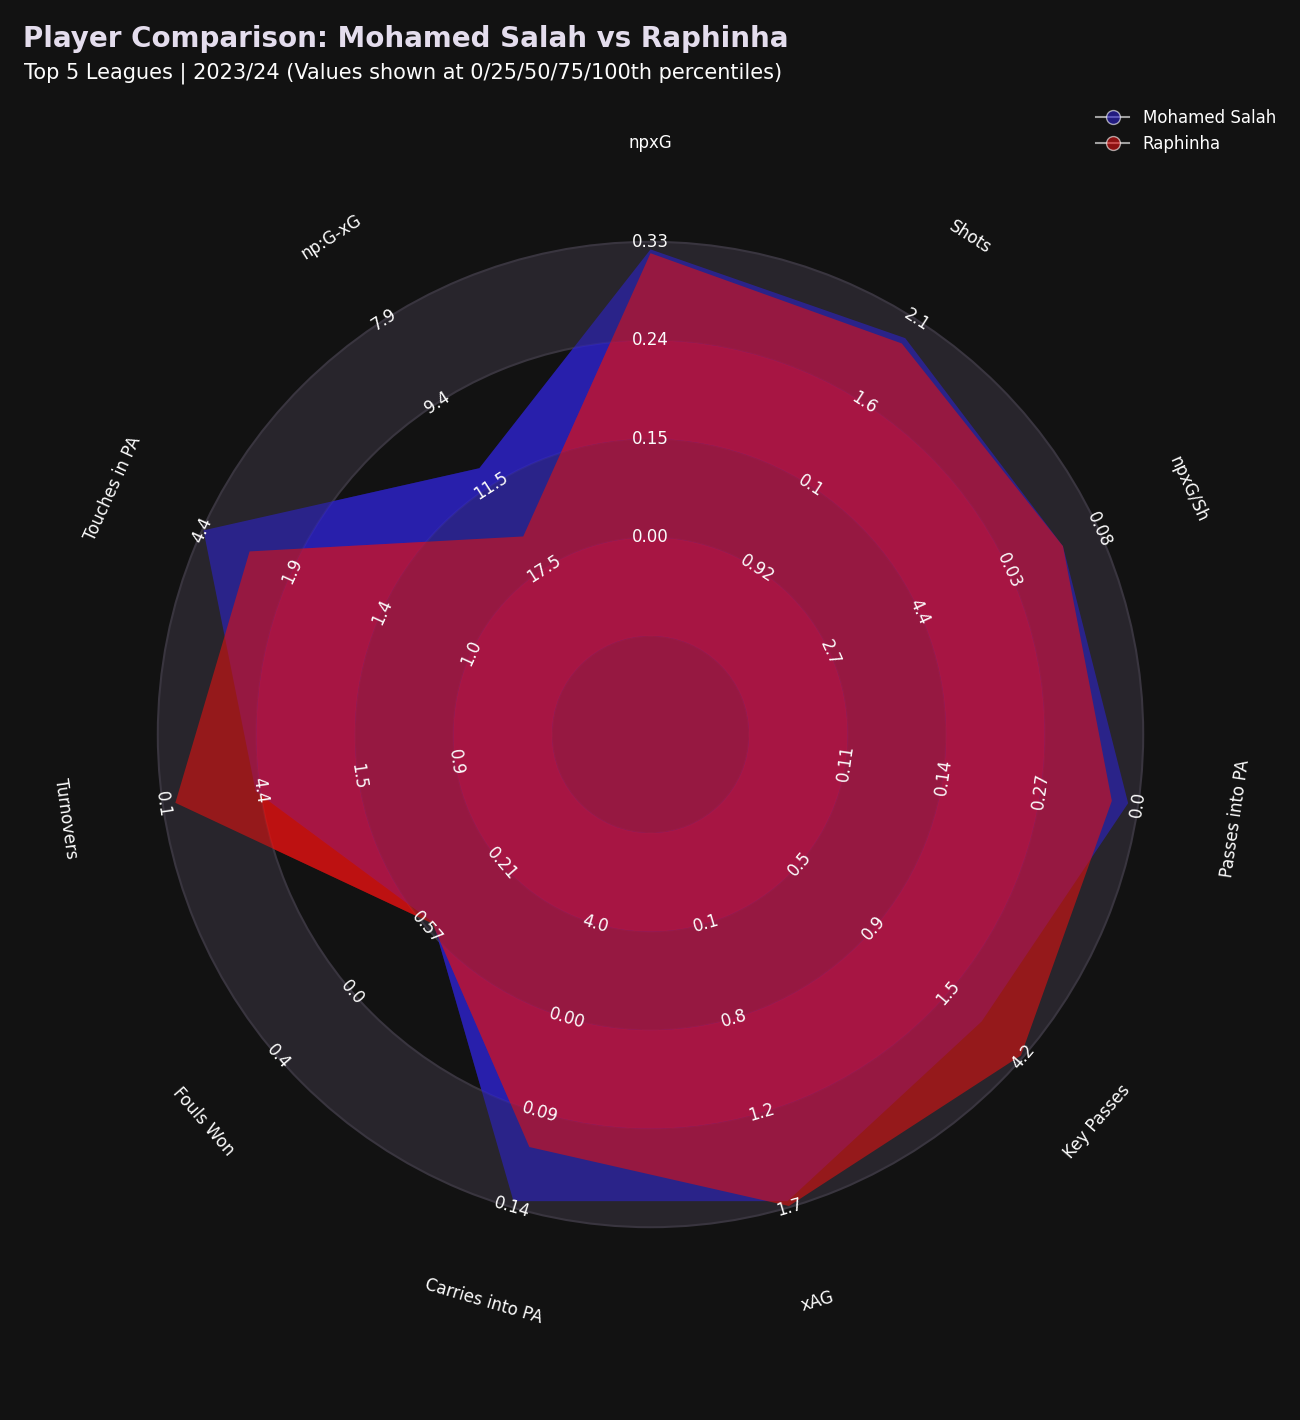

In [38]:
from mplsoccer import Radar, grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_radar_chart(df, player1_name, player2_name=None):
    if player1_name not in df['player'].values:
        print(f"Player {player1_name} not found in dataset.")
        print("Available players:")
        print(df['player'].values)
        raise ValueError(f"Player {player1_name} not found")
    
    numeric_df = df.copy()
    
    metrics = ["npxG", "Shots", "npxG/Sh", 
              "Passes into PA", "Key Passes", "xAG", "Carries into PA", "Fouls Won", "Turnovers",
              "Touches in PA", "np:G-xG"]
    
    # Convert metrics to numeric
    for metric in metrics:
        numeric_df[metric] = pd.to_numeric(df[metric], errors='coerce')
    
    # Calculate percentiles for each metric
    percentile_df = numeric_df.copy()
    for metric in metrics:
        if metric == 'Turnovers':  # For metrics where lower is better
            percentile_df[metric] = 100 - numeric_df[metric].rank(pct=True) * 100
        else:
            percentile_df[metric] = numeric_df[metric].rank(pct=True) * 100
    
    # Set up min and max ranges for percentiles (0-100)
    min_ranges = [0] * len(metrics)
    max_ranges = [100] * len(metrics)

    radar = Radar(
        params=metrics,
        min_range=min_ranges,
        max_range=max_ranges,
        lower_is_better=['Turnovers']
    )

    fig, axs = grid(
        figheight=14,
        grid_height=0.915,
        title_height=0.06,
        endnote_height=0.025,
        title_space=0,
        endnote_space=0,
        grid_key='radar',
        axis=False
    )

    radar.setup_axis(ax=axs['radar'], facecolor='None')
    rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#28252c', edgecolor='#39353f', lw=1.5)

    player1_percentiles = percentile_df[percentile_df['player'] == player1_name][metrics].iloc[0].tolist()
    player1_values = numeric_df[numeric_df['player'] == player1_name][metrics].iloc[0]
    
    radar_output_1 = radar.draw_radar(
        player1_percentiles,
        ax=axs['radar'],
        kwargs_radar={'facecolor': '#2D22C9', 'alpha': 0.6},
        kwargs_rings={'facecolor': '#2D22C9', 'alpha': 0.6}
    )

    if player2_name:
        player2_percentiles = percentile_df[percentile_df['player'] == player2_name][metrics].iloc[0].tolist()
        player2_values = numeric_df[numeric_df['player'] == player2_name][metrics].iloc[0]
        radar_output_2 = radar.draw_radar(
            player2_percentiles,
            ax=axs['radar'],
            kwargs_radar={'facecolor': '#DF1111', 'alpha': 0.6},
            kwargs_rings={'facecolor': '#DF1111', 'alpha': 0.6}
        )

    # Draw range labels with actual values at percentile points
    range_labels = radar.draw_range_labels(
        ax=axs['radar'],
        fontsize=12,
        color='#fcfcfc'
    )

    # Modify the range labels to show actual values at percentiles
    for i, label in enumerate(range_labels):
        metric = metrics[i // 5]  # Get current metric
        value_idx = i % 5  # Get index for current ring (0-4)
        
        # Get the actual value at this percentile
        if metric == 'Turnovers':
            perc = [100, 75, 50, 25, 0][value_idx]  # Reverse for lower-is-better
        else:
            perc = [0, 25, 50, 75, 100][value_idx]
        
        value = np.percentile(numeric_df[metric], perc)
        
        # Format based on the type of metric
        if metric in ["npxG", "xAG", "npxG/Sh", "np:G-xG"]:
            label.set_text(f"{value:.2f}")
        elif metric in ["Shots", "Passes into PA", "Touches in PA", "Key Passes", "Carries into PA", "Fouls Won", "Turnovers"]:
            label.set_text(f"{value:.1f}")
        else:
            label.set_text(f"{value:.2f}")

    param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=12, color='#fcfcfc')

    title1_text = axs['title'].text(
        0.01, 0.65,
        f"Player Comparison: {player1_name}" + (f" vs {player2_name}" if player2_name else ""),
        fontsize=20,
        ha='left',
        va='center',
        color='#e4dded',
        fontdict={"fontweight": "bold"}
    )

    axs['title'].text(0.011, 0.25, 'Top 5 Leagues | 2023/24 (Values shown at 0/25/50/75/100th percentiles)', 
                     fontsize=15, ha='left', va='center', color='#fcfcfc')

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='#2D22C9', markersize=10, 
                  alpha=0.6, label=f'{player1_name}'),
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='#DF1111', markersize=10, 
                  alpha=0.6, label=f'{player2_name}' if player2_name else '')
    ]
    
    axs['radar'].legend(handles=legend_elements, 
                       loc='upper right',
                       facecolor='#121212',
                       edgecolor='None',
                       labelcolor='white',
                       fontsize=12)

    fig.set_facecolor('#121212')
    return fig

try:
    player1 = 'Mohamed Salah'
    player2 = 'Raphinha'
    print(f"\nCreating chart for: {player1} vs {player2}")
    fig = create_radar_chart(df, player1, player2)
    plt.show()
except Exception as e:
    print(f"Error occurred: {str(e)}")